# Explore network activity profile

We will now explore how consistent in time seems to be the wave of activation that spreads through our ring of neurons.

In [8]:
%matplotlib widget

import lotr.plotting as pltltr
import numpy as np
from lotr import A_FISH, FIGURES_LOCATION, LotrExperiment, dataset_folders
from lotr.pca import fit_phase_neurons, pca_and_phase
from lotr.utils import interpolate, roll_columns_jit, zscore
from matplotlib import pyplot as plt
from tqdm import tqdm

COLS = pltltr.COLS

fig_location = FIGURES_LOCATION / "3_activity_prof"
fig_location.mkdir(exist_ok=True)

## Profile over time

First, we will find a way of shifting columns of the activation matrix over time so that the peak of the network activation is always in the same roughly consistent position

In [9]:
exp = LotrExperiment(A_FISH)

# Find sorting over neurons according to angles...
sort_idxs = np.argsort(exp.rpc_angles)

# ...and apply it to sort the traces:
sorted_traces = exp.traces[:, exp.hdn_indexes[sort_idxs]]

# Find the right amount of shift over time to have the bump centered:
# by first stretching phase to (-0.5, 0.5) interval and then
# to (-n_rois//2, n_rois//2) interval. In this way, we will center
# phase 0 of the network on position of angle 0:
phase_shifts = (exp.network_phase / (2 * np.pi)) * (exp.n_hdns - 1)

# Then, apply shifts to traces:
shifted_traces = roll_columns_jit(sorted_traces, -np.round(phase_shifts))

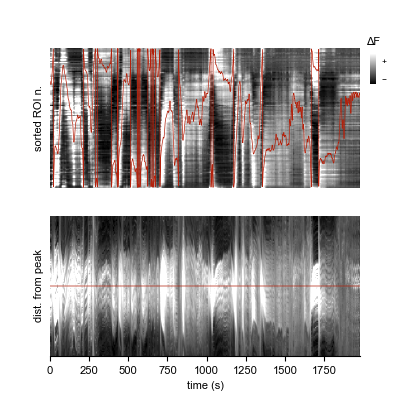

In [10]:
flims = 1.7

f, axs = plt.subplots(2, 1, figsize=(4, 4))

for i, traces in enumerate([sorted_traces, shifted_traces]):
    c = axs[i].imshow(
        traces.T,
        aspect="auto",
        extent=(0, exp.n_pts / exp.fn, 0, exp.n_hdns),
        vmin=-flims,
        vmax=flims,
        cmap=COLS["dff_plot"],
    )
for i, line in enumerate(
    [phase_shifts + exp.n_hdns / 2, np.ones(exp.n_pts) * exp.n_hdns / 2]
):
    axs[i].plot(exp.time_arr, line, lw=0.5, c=COLS["ph_plot"])

pltltr.despine(axs[0], "all")
pltltr.despine(axs[1], ["left", "right", "top"])
pltltr.add_dff_cbar(c, axs[0], (1.05, 0.78, 0.02, 0.22))

axs[1].set(xlabel="time (s)", ylabel="dist. from peak")
axs[0].set(ylabel="sorted ROI n.")
pltltr.savefig(fig_location / "phase_centered_traces.pdf")

### Improve shift by interpolation

This looks nice, but we could potentially improve it! Above, we were shifting the activation bump assuming that neurons where equally spaced across all possible angles in rPC space. However, this might not be the case, and we actually know that we can have non-homogeneous distribution on neurons along the circle.
Let's see if we can improve things by interpolating the traces to sample homogeneously along the circle before shifting:

In [11]:
# arbitrary number of bins for the resampling:
N_BINS_RESAMPLED = 100

# we will resample over the (-pi, pi) interval
resampling_base = np.linspace(-np.pi, np.pi, N_BINS_RESAMPLED)

angle_resampled_traces = np.zeros((exp.n_pts, N_BINS_RESAMPLED))
for i in range(exp.n_pts):
    angle_resampled_traces[i, :] = np.interp(
        resampling_base,
        exp.rpc_angles[sort_idxs],
        exp.traces[i, exp.hdn_indexes[sort_idxs]],
    )

# Then, we repeat:
phase_shifts_resamp = (exp.network_phase / (2 * np.pi)) * (N_BINS_RESAMPLED - 1)
shifted_traces_resamp = roll_columns_jit(
    angle_resampled_traces, -np.round(phase_shifts_resamp)
)

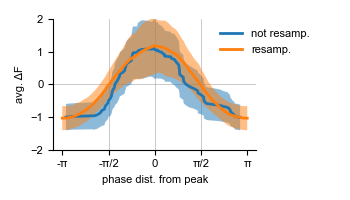

In [12]:
f_lims = dict(vmin=-1.7, vmax=1.7)
f, ax = plt.subplots(1, 1, figsize=(3.5, 2))

for i, (lab, x, traces) in enumerate(
    zip(
        ["not resamp.", "resamp."],
        [exp.rpc_angles[sort_idxs], resampling_base],
        [shifted_traces, shifted_traces_resamp],
    )
):

    mn, sd = traces.mean(0), traces.std(0)
    (p,) = ax.plot(x, mn, lw=2, label=lab)
    ax.fill_between(x, mn - sd, mn + sd, lw=0, alpha=0.5, label="_nolegend_")


ax.set(
    xlabel="phase dist. from peak",
    ylabel="avg. ΔF",
    ylim=(-2, 2),
    **pltltr.get_pi_labels(d=0.5)
)
ax.legend(bbox_to_anchor=(1.3, 1, 0.01, 0.0))
for l in [-1 / 2, 0, 1 / 2]:
    plt.axvline(l * np.pi, lw=0.5, c=".7", zorder=-100)
plt.axhline(0, lw=0.5, c=".7", zorder=-100)
pltltr.despine(ax)

plt.tight_layout()
pltltr.savefig(fig_location / "pre_post_interp.svg")

This looks definitively better!

## Loop over all fish 
Now, let's compare phase activations across fish from the entire dataset. The steps have been wrapped in the `lotr.analysis.activity_profile.resample_and_shift()` function:

In [13]:
from lotr.analysis.activity_profile import resample_and_shift

resamp, reshaped = resample_and_shift(exp)
assert np.allclose(angle_resampled_traces, resamp, rtol=0.001)
assert np.allclose(shifted_traces_resamp, reshaped, rtol=0.001)

In [14]:
N_BINS_RESAMP = 100

all_mn_profiles = []
all_std_profiles = []

for path in tqdm(dataset_folders):
    _, shifted_resamp_traces = resample_and_shift(
        LotrExperiment(path), n_bins_resampling=N_BINS_RESAMP
    )

    all_mn_profiles.append(shifted_resamp_traces.mean(0))
    all_std_profiles.append(shifted_resamp_traces.std(0))

all_mn_profiles = np.array(all_mn_profiles)
all_std_profiles = np.array(all_std_profiles)

100%|███████████████████████████████████████████| 31/31 [00:51<00:00,  1.66s/it]


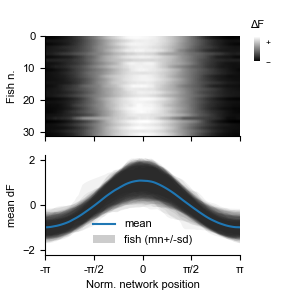

In [27]:
f, axs = plt.subplots(
    2,
    1,
    gridspec_kw=dict(left=0.15, bottom=0.15, right=0.8),
    figsize=(3, 3),
    sharex=True,
)


for mn, std in zip(all_mn_profiles, all_std_profiles):
    axs[1].fill_between(
        resampling_base,
        mn - std,
        mn + std,
        lw=0,
        fc=".0",
        alpha=0.05,
        label="_nolegend_",
    )
axs[1].fill_between([], [], [], lw=0, fc=".0", alpha=0.2, label="fish (mn+/-sd)")
axs[1].plot(resampling_base, all_mn_profiles.mean(0), label="mean")
axs[1].legend()
axs[1].set(
    xlabel="Norm. network position",
    ylabel="mean dF",
    ylim=(-2.2, 2.2),
    **pltltr.get_pi_labels(d=0.5)
)
axs[0].imshow(
    all_mn_profiles,
    aspect="auto",
    extent=[-np.pi, np.pi, all_mn_profiles.shape[0], 0],
    cmap=COLS["dff_plot"],
)
pltltr.add_dff_cbar(c, axs[0], (1.1, 0.8, 0.03, 0.25))
axs[0].set(ylabel="Fish n.")
[pltltr.despine(ax) for ax in axs]

pltltr.savefig(fig_location / "all_fish_profiles.pdf")

## Activation profile and behavior
Next interesting question is: is the bump sustained also when fish is not swimming? How much can it persist after last bout?

We will proceed in the following way: we will create an array that specifies for each frame how much time elapsed from the last bout, and we will then average frames by such distance.

In [17]:
from lotr.behavior import get_bouts_props_array


def get_frames_elapsed(exp):
    # Get array of ones in correspondence of a bout:
    bouts_arr = get_bouts_props_array(
        exp.n_pts, exp.bouts_df, min_bias=0, selection="all", value=1
    )

    frames_elapsed = np.zeros(bouts_arr.shape)

    # Loop and count:
    for t in range(1, len(bouts_arr)):
        if bouts_arr[t] == 1:
            frames_elapsed[t] = 0
        else:
            frames_elapsed[t] = frames_elapsed[t - 1] + 1

    return frames_elapsed, bouts_arr


exp = LotrExperiment(A_FISH)

frames_elapsed, bouts_arr = get_frames_elapsed(exp)

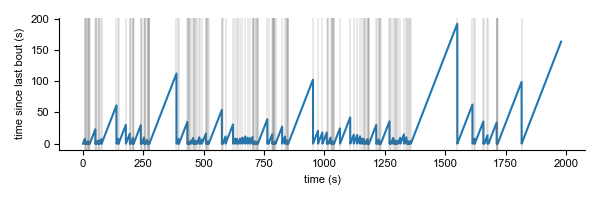

In [18]:
f, ax = plt.subplots(figsize=(6, 2))
ax.plot(exp.time_arr, frames_elapsed / exp.fn)

for t in range(1, len(bouts_arr)):
    if bouts_arr[t] == 1:
        ax.axvline(t / exp.fn, lw=0.2, c=".4")
ax.set(xlabel="time (s)", ylabel="time since last bout (s)")

pltltr.despine(ax)
plt.tight_layout()
pltltr.savefig(fig_location / "time_elapsed_expl.pdf")

In [19]:
# Now, loop over possible distances and average all activation profiles corresponding that
# distance.
_, reshaped = resample_and_shift(exp)

max_el_count = 300  # maximum elapsed count, in frames

mean_activations = np.zeros((max_el_count, reshaped.shape[1]))

for f_count in range(max_el_count):
    frames_sel = frames_elapsed == f_count
    mean_activations[f_count, :] = reshaped[frames_sel, :].mean(0)

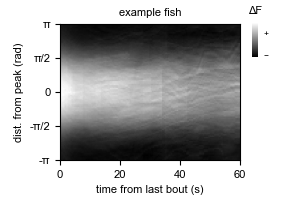

/var/folders/2_/dvscqkzj7rj7chs9sk8ysjfm0000gn/T/ipykernel_1214/2403795772.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [20]:
f, ax = plt.subplots(figsize=(3, 2), gridspec_kw=dict(left=0.2, bottom=0.2, right=0.8),)
c = plt.imshow(
    mean_activations.T,
    aspect="auto",
    extent=[0, mean_activations.shape[0] / exp.fn, -np.pi, np.pi],
    cmap=COLS["dff_plot"],
)

ax.set(
    title="example fish",
    xlabel="time from last bout (s)",
    ylabel="dist. from peak (rad)",
    **pltltr.get_pi_labels(0.5, ax="y")
)
pltltr.add_dff_cbar(c, ax, (1.1, 0.8, 0.03, 0.25))
plt.show()
plt.tight_layout()

pltltr.savefig(fig_location / "bump_after_bout_example_fish.pdf")

This looks promising! Let's now look at the average across the full dataset. We well also keep track of how many frames we have for each elapsed time.
As a control, we look at the not- reshaped array, to both get a noise level and
make sure there is not just a stable activation profile to which the network converges.

In [22]:
FN = 5  # impose sampling, only 1/31 experiments will be excluded
max_el_count = 900  # 3 minutes at 5 Hz
n_bins_resamp = 100  # resample network over 100 points
min_frames_avg = 3  # minimum number of frames for a given latency to include the fish
min_fish_avg = 3  # minimum number of fish for a given latency to include the latency

all_profiles_cnt = []  # control profiles
all_profiles = []  # all profiles from reshaped neurons
all_histograms = []  # keep track of frame counts

for path in tqdm(dataset_folders):
    exp = LotrExperiment(path)

    # Skip the one exp with 3 Hz to avoid resampling in time:
    if exp.fn != FN:
        continue
    # Get resmpled traces:
    resamp, shifted = resample_and_shift(exp, n_bins_resampling=n_bins_resamp)

    # Get frames elapsed:
    frames_elapsed, _ = get_frames_elapsed(exp)

    mean_activations = np.full((max_el_count, n_bins_resamp), np.nan)
    cnt_activations = np.full((max_el_count, n_bins_resamp), np.nan)

    frames_hist = np.full(max_el_count, np.nan)

    for f_count in range(max_el_count):
        frames_sel = frames_elapsed == f_count
        frames_hist[f_count] = np.sum(frames_sel)

        if frames_hist[f_count] > min_frames_avg:  # avoid too small slices
            mean_activations[f_count, :] = np.nanmean(shifted[frames_sel, :], 0)
            cnt_activations[f_count, :] = np.nanmean(resamp[frames_sel, :], 0)

    all_profiles.append(mean_activations)
    all_profiles_cnt.append(cnt_activations)
    all_histograms.append(frames_hist)

all_profiles = np.array(all_profiles)
all_profiles_cnt = np.array(all_profiles_cnt)
all_histograms = np.array(all_histograms)

100%|███████████████████████████████████████████| 31/31 [00:52<00:00,  1.69s/it]


In [23]:
# include only time points with enough fish
valid_tpts = np.isnan(all_profiles).all(2).sum(0) < (
    all_profiles.shape[0] - min_fish_avg
)
all_profiles = all_profiles[:, valid_tpts, :]
all_profiles_cnt = all_profiles_cnt[:, valid_tpts, :]
all_histograms = all_histograms[:, valid_tpts]

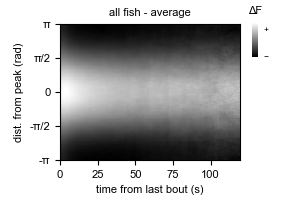

/var/folders/2_/dvscqkzj7rj7chs9sk8ysjfm0000gn/T/ipykernel_1214/2812810092.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


In [24]:
mean_activations = np.nanmean(all_profiles, 0)
f, ax = plt.subplots(figsize=(3, 2), gridspec_kw=dict(left=0.2, bottom=0.2, right=0.8),)
c = plt.imshow(
    mean_activations.T,
    aspect="auto",
    extent=[0, mean_activations.shape[0] / exp.fn, -np.pi, np.pi],
    cmap=COLS["dff_plot"],
)

ax.set(
    title="all fish - average",
    xlabel="time from last bout (s)",
    ylabel="dist. from peak (rad)",
    **pltltr.get_pi_labels(0.5, ax="y")
)
pltltr.add_dff_cbar(c, ax, (1.1, 0.8, 0.03, 0.25))
plt.show()
plt.tight_layout()

pltltr.savefig(fig_location / "bump_after_bout_all_fish.pdf")

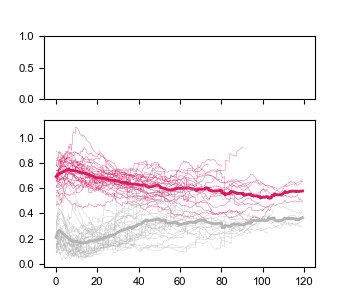

In [26]:
f, axs = plt.subplots(
    2, 1, figsize=(3.5, 3), gridspec_kw=dict(height_ratios=(0.3, 0.7)), sharex=True
)

time_arr = np.arange(all_profiles.shape[1]) / FN
for prof, col, lab in zip(
    [all_profiles, all_profiles_cnt],
    [COLS["ring"], ".7"],
    ["peak centered", "not centered"],
):
    abs_dff_prof = np.abs(prof).mean(2)
    axs[1].plot(time_arr, abs_dff_prof.T, lw=0.2, c=col, label="_nolegend_")
    axs[1].plot(time_arr, np.nanmean(abs_dff_prof, 0), lw=2, c=col, label=lab)
plt.show()
axs[1].set(xlabel="time from last bout (s)", ylabel="bump mean(abs(ΔF))")
axs[1].legend()

for hist in all_histograms:
    axs[0].fill_between(
        time_arr, np.zeros(hist.shape), hist, alpha=0.02, fc=".0", lw=0.0
    )
# axs[0].plot(time_arr, all_histograms.T, c=".3", lw=0.3)
# axs[0].plot(time_arr, all_histograms.mean(0), c=COLS["ring"])
axs[0].set(yscale="log", ylabel="frames count")

plt.tight_layout()
[pltltr.despine(ax) for ax in axs]

pltltr.savefig(fig_location / "bump_evolution_in_time.pdf")